In [30]:
import scipy.io as sio
import pandas as pd
import numpy as np
import scipy as scipy

import dnatools
import os

from pylab import find, figure, mean, size, sign, log, exp
from keras.utils.generic_utils import get_custom_objects

In [1]:
import sys
sys.path.append('../helper')
import common as cm

Using TensorFlow backend.


## Summary
- Load mutation data
- Predict data using HAL method
- Load our trained model and predict data using our method
- Compare results of our method vs HAL method

## Helper functions

In [4]:
# function to find the mut position
def find_seq_diff_pos(wt_seq,mut_seq):
    """ Function to find the actual position of mutations based
    on the WT and MUT seq"""
    muts = np.zeros(len(wt_seq))
    for i in range(len(wt_seq)):
        muts[i] = (wt_seq[i]!=mut_seq[i])
    return find(muts)[0]

In [5]:
# function to get the score of the seq (HAL)
logit = lambda x: log(x)-log(1-x)
expit = lambda x: 1./(1.+exp(-x))

def score_seq_HAL(seq,mer_scores):
    score = 0.
    for b in range(4):
        score -= sd_scores.ix[seq[b:b+6],b]
    for b in range(0,len(seq)-5-6-3):
        score += mer_scores[seq[b:b+6]]
    # Score the SD:
    for b in range(4):
        score += sd_scores.ix[seq[len(seq)-9+b:len(seq)-9+6+b],b]
    return score

In [7]:
# functions to get the accurate and statistics
def get_accuracy(predictions,data):
    accuracy = {'Correct':sum(sign(predictions)==sign(data)),
                'Incorrect':sum(sign(-predictions)==sign(data)),
                'Total':len(predictions),
                'Total_with_Change':sum(abs(data)>0),
                'R2':scipy.stats.pearsonr(predictions,data)[0]**2,
                'R2_P_value':scipy.stats.pearsonr(predictions,data)[1]}
    return accuracy

def get_prediction_stats():
    prediction_accuracy = {}
    # Heterozygous SNPs in SDs:
    SNP_SD_HETERO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HETERO_COUNTS.apply(size)>=2)&SNP_df.SS_MUT]
    prediction_accuracy['SD_SNP_HETERO'] = get_accuracy(SNP_SD_HETERO.HETERO_DPSI_PRED,SNP_SD_HETERO.HETERO_DPSI)
    prediction_accuracy['SD_SNP_HETERO_HAL'] = get_accuracy(SNP_SD_HETERO.HETERO_DPSI_PRED_HAL,SNP_SD_HETERO.HETERO_DPSI)
    
    SNP_SD_HETERO_LARGE = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HETERO_COUNTS.apply(size)>=2)&\
                                 SNP_df.SS_MUT & SNP_df.LARGE_HETERO_EFFECT]
    prediction_accuracy['SD_SNP_HETERO_LARGE'] = get_accuracy(SNP_SD_HETERO_LARGE.HETERO_DPSI_PRED,SNP_SD_HETERO_LARGE.HETERO_DPSI)
    prediction_accuracy['SD_SNP_HETERO_LARGE_HAL'] = get_accuracy(SNP_SD_HETERO_LARGE.HETERO_DPSI_PRED_HAL,SNP_SD_HETERO_LARGE.HETERO_DPSI)
   
    SNP_SD_HOMO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HOMO_COUNTS.apply(size)>=2)&SNP_df.SS_MUT]
    prediction_accuracy['SD_SNP_HOMO'] = get_accuracy(SNP_SD_HOMO.HETERO_DPSI_PRED,SNP_SD_HOMO.HETERO_DPSI)
    prediction_accuracy['SD_SNP_HOMO_HAL'] = get_accuracy(SNP_SD_HOMO.HETERO_DPSI_PRED_HAL,SNP_SD_HOMO.HETERO_DPSI)
    
    SNP_SD_HOMO_LARGE = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HOMO_COUNTS.apply(size)>=2)&\
                                 SNP_df.SS_MUT & SNP_df.LARGE_HOMO_EFFECT]
    prediction_accuracy['SD_SNP_HOMO_LARGE'] = get_accuracy(SNP_SD_HOMO_LARGE.HOMO_DPSI_PRED,SNP_SD_HOMO_LARGE.HOMO_DPSI)
    prediction_accuracy['SD_SNP_HOMO_LARGE_HAL'] = get_accuracy(SNP_SD_HOMO_LARGE.HOMO_DPSI_PRED_HAL,SNP_SD_HOMO_LARGE.HOMO_DPSI)
    
    prediction_accuracy = pd.DataFrame(prediction_accuracy)
    print(prediction_accuracy.T)
    return prediction_accuracy

In [67]:
# function to predict mutation using cnn model
def prediction_mutation(model1, model2, coeff = 1, bias = 0):
    
    SNP_df["MUT_EFFECT_SIZE"] = SNP_df.MUT_SEQ.apply(lambda s:seq_psi_predict(s, model1,model2, sd1 = True))-\
                            SNP_df.WT_SEQ.apply(lambda s:seq_psi_predict(s, model1,model2, sd1 = True))
    
    SNP_df['HOMO_PRED'] = expit(logit(SNP_df.WT_PSI)+coeff*SNP_df.MUT_EFFECT_SIZE + bias)
    SNP_df['HETERO_PRED'] = (SNP_df.WT_PSI+SNP_df.HOMO_PRED)/2.
    SNP_df['HETERO_DPSI_PRED'] = SNP_df.HETERO_PRED-SNP_df.WT_PSI
    SNP_df['HOMO_DPSI_PRED'] = SNP_df.HOMO_PRED-SNP_df.WT_PSI

def seq_psi_predict(s, model1, model2,  sd1 = False):
    predict1 = model1.predict({'seq':encodeDNA([s[202-int(seqL/2):202-int(seqL/2) + seqL]])})[0]
    predict2 = model2.predict({'seq':encodeDNA([s[-199-int(seqL/2):-199-int(seqL/2) + seqL]])})[0]
    return -predict1[0] + predict2[0]

# just brute force method to find the optimal coeff
def find_coeff():
    coeff = -1
    for i in range(20):
        coeff = coeff + 0.1

        prediction_mutation(sub_model, sub_model2, coeff)
        inds_hetero = find((SNP_df.HETERO_COUNTS.apply(size)>=2) & (SNP_df.WT_COUNTS.apply(size)>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
        inds_homo = find((SNP_df.HOMO_COUNTS.apply(size)>=2) & (SNP_df.WT_COUNTS.apply(size)>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
        r2= scipy.stats.pearsonr(np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI,
                                             SNP_df.iloc[inds_homo].HOMO_DPSI)),
                             np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED,
                                             SNP_df.iloc[inds_homo].HOMO_DPSI_PRED)))[0]**2
        
        print(str(i) + " " + str(r2))


## Get mutation data information

In [8]:
SNP_df = pd.read_pickle('../data/All_SNPs.df')

#Get_gene_names:
header = ['chrom','splice_type','type','start','end','misc_1','strand','misc_2','ID']
A5SS = pd.read_csv('../ref/hg19_v2/A5SS.hg19.gff3',sep='\t',skiprows=1,names=header)
A5SS_events = A5SS[A5SS.type=='gene']
A5SS_events['gene'] = A5SS_events.ID.apply(lambda ID:ID.split(';')[-2].split('gsymbol=')[1])
gene_names = pd.Series(dict(zip(A5SS_events.ID.apply(lambda s:s[5:].split(';')[0]),A5SS_events.gene)))
SNP_df['GENE'] = gene_names[SNP_df.EVENT].values


SNP_df = SNP_df[SNP_df.WT_SEQ.apply(len)==SNP_df.MUT_SEQ.apply(len)]

# Find the actual location of SNPs. The listed positions might be wrong:
SNP_df['SNP_POS'] = SNP_df.apply(lambda x:find_seq_diff_pos(x['WT_SEQ'],x['MUT_SEQ']),axis=1)
SNP_df['WT_PSI'] = SNP_df.WT_PSI.apply(mean)
SNP_df['HETERO_PSI'] = SNP_df.HETERO_PSI.apply(mean)
SNP_df['HOMO_PSI'] = SNP_df.HOMO_PSI.apply(mean)

# Filter the SNPs
SNP_df = SNP_df[(SNP_df.SD_DIST<250)  &\
                (SNP_df.SNP_POS>197) & ((SNP_df.WT_SEQ.apply(len)-SNP_df.SNP_POS)>194)]
SNP_df = SNP_df[SNP_df.WT_SEQ.apply(len) > 252]
SNP_df['SD1_MUT'] = ((SNP_df.SNP_POS<=206) & (SNP_df.SNP_POS>197) )
SNP_df['SD2_MUT'] = (((SNP_df.WT_SEQ.apply(len)-SNP_df.SNP_POS)<=203 ) & ((SNP_df.WT_SEQ.apply(len)-SNP_df.SNP_POS)>=194) )
SNP_df['SS_MUT'] = SNP_df.SD1_MUT | SNP_df.SD2_MUT
SNP_df = SNP_df[SNP_df['SS_MUT']]

## get actual value
SNP_df['LARGE_HETERO_EFFECT'] = abs(SNP_df.WT_PSI.apply(mean)-SNP_df.HETERO_PSI.apply(mean))>0.05
SNP_df['LARGE_HOMO_EFFECT'] = abs(SNP_df.WT_PSI.apply(mean)-SNP_df.HOMO_PSI.apply(mean))>0.05
SNP_df['HETERO_DPSI'] = SNP_df.HETERO_PSI-SNP_df.WT_PSI
SNP_df['HOMO_DPSI'] = SNP_df.HOMO_PSI-SNP_df.WT_PSI

/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Prediction from HAL

In [9]:
# Load Splice Site Model
data = sio.loadmat('../data/model_full_data.mat')
sd_scores = pd.DataFrame(index=dnatools.make_mer_list(6),data=data['Mer_scores'][:4**6*8].reshape(4**6,8)[:,2:6])
exonic_mer6_scores = pd.read_pickle('../data/exonic_mer6_scores.series')

SNP_df['MUT_EFFECT_SIZE_HAL'] = SNP_df.MUT_SEQ.str.slice(198,-194).apply(lambda s:score_seq_HAL(s,exonic_mer6_scores))-\
                            SNP_df.WT_SEQ.str.slice(198,-194).apply(lambda s:score_seq_HAL(s,exonic_mer6_scores))
    
SNP_df['HOMO_PRED_HAL'] = expit(logit(SNP_df.WT_PSI)+SNP_df.MUT_EFFECT_SIZE_HAL)
SNP_df['HETERO_PRED_HAL'] = (SNP_df.WT_PSI+SNP_df.HOMO_PRED_HAL)/2.
SNP_df['HETERO_DPSI_PRED_HAL'] = SNP_df.HETERO_PRED_HAL-SNP_df.WT_PSI
SNP_df['HOMO_DPSI_PRED_HAL'] = SNP_df.HOMO_PRED_HAL-SNP_df.WT_PSI


/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


## Load trained model

load the trained model and get the sub model from the train model

In [ ]:
#get result folder
resultsdir = '../results'

load trained model

In [ ]:
# load model
get_custom_objects()['r2_score_k'] = cm.r2_score_k
model_sm = load_model(resultsdir + 'model_58seq_sm_3differentdense2.h5')

In [71]:
model_sm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
seq0 (InputLayer)                (None, 100, 4)        0                                            
____________________________________________________________________________________________________
seq1 (InputLayer)                (None, 100, 4)        0                                            
____________________________________________________________________________________________________
seq2 (InputLayer)                (None, 100, 4)        0                                            
____________________________________________________________________________________________________
seq3 (InputLayer)                (None, 100, 4)        0                                            
___________________________________________________________________________________________

create sub model for SD1

In [72]:
# create sub model
model_input = kl.Input(shape=(100,4), name='seq')

x = cl.ConvDNA(filters=128, kernel_size=15, activation="relu")(model_input) 
x = kl.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
x = kl.Flatten()(x)
x = kl.Dense(units=1, kernel_regularizer=regularizers.l1(1e-8))(x)
x = kl.Dense(units=1, kernel_regularizer=regularizers.l1(1e-8))(x)

sub_model = Model(inputs=[model_input], outputs=x)


In [73]:
sub_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq (InputLayer)             (None, 100, 4)            0         
_________________________________________________________________
conv_dna_3 (ConvDNA)         (None, 86, 128)           7808      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 86, 128)           16512     
_________________________________________________________________
flatten_3 (Flatten)          (None, 11008)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11009     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 35,331
Trainable params: 35,331
Non-trainable params: 0
_________________________________________________________________


In [75]:
# set the weight of sub model correspoding to to weight of the train model
sub_model.get_layer('conv_dna_3').set_weights(model_sm.get_layer('conv_dna_11').get_weights())
sub_model.get_layer('conv1d_3').set_weights(model_sm.get_layer('conv1d_11').get_weights())
sub_model.get_layer('dense_5').set_weights(model_sm.get_layer('dense_374').get_weights())
sub_model.get_layer('dense_6').set_weights(model_sm.get_layer('dense_378').get_weights())

create sub model for SD2

In [76]:
sub_model2 = Model(inputs=[model_input], outputs=x)
sub_model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq (InputLayer)             (None, 100, 4)            0         
_________________________________________________________________
conv_dna_3 (ConvDNA)         (None, 86, 128)           7808      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 86, 128)           16512     
_________________________________________________________________
flatten_3 (Flatten)          (None, 11008)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11009     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 35,331
Trainable params: 35,331
Non-trainable params: 0
_________________________________________________________________


In [82]:
sub_model2.get_layer('conv_dna_3').set_weights(model_sm.get_layer('conv_dna_11').get_weights())
sub_model2.get_layer('conv1d_3').set_weights(model_sm.get_layer('conv1d_11').get_weights())
sub_model2.get_layer('dense_5').set_weights(model_sm.get_layer('dense_374').get_weights())
sub_model2.get_layer('dense_6').set_weights(model_sm.get_layer('dense_406').get_weights())

## Predict data

In [83]:
seqL = 100
prediction_mutation(sub_model2, sub_model2, coeff = 2)
prediction_accuracy = get_prediction_stats()

                         Correct  Incorrect        R2    R2_P_value  Total  \
SD_SNP_HETERO              158.0       42.0  0.471395  4.400548e-29  199.0   
SD_SNP_HETERO_HAL          154.0       46.0  0.469381  6.412517e-29  199.0   
SD_SNP_HETERO_LARGE         81.0       12.0  0.679699  3.204610e-24   93.0   
SD_SNP_HETERO_LARGE_HAL     81.0       12.0  0.676984  4.714628e-24   93.0   
SD_SNP_HOMO                 55.0        9.0  0.481962  1.998420e-10   64.0   
SD_SNP_HOMO_HAL             50.0       14.0  0.416589  8.517321e-09   64.0   
SD_SNP_HOMO_LARGE           33.0        2.0  0.627996  1.404019e-08   35.0   
SD_SNP_HOMO_LARGE_HAL       35.0        0.0  0.593250  6.288338e-08   35.0   

                         Total_with_Change  
SD_SNP_HETERO                        198.0  
SD_SNP_HETERO_HAL                    198.0  
SD_SNP_HETERO_LARGE                   93.0  
SD_SNP_HETERO_LARGE_HAL               93.0  
SD_SNP_HOMO                           64.0  
SD_SNP_HOMO_HAL            

/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


### Plot charts

In [51]:
def plot_snps(ax,df,yticks=True):
    df = df.sort(['SS_MUT','WT_PSI'])
    df.WT_PSI.plot(ax=ax,kind='bar',color=cur_cols)
    ax.set_xticks(arange(len(df))+1)
    ax.set_xticklabels(df.GENE.values,rotation=45,ha='right')
    for i in xrange(len(df)):
        ax.plot([i+0.4,i+0.4],[df.WT_PSI.values[i],df.HETERO_PSI.values[i]],color=c1)
        ax.plot([i+0.8,i+0.8],[df.WT_PSI.values[i],df.HETERO_PRED.values[i]],color=c2)
        if pd.notnull(df.HOMO_PSI.values[i]):
            ax.plot([i+0.4,i+0.4],[df.WT_PSI.values[i],df.HOMO_PSI.values[i]],color=c1)
            ax.plot([i+0.8,i+0.8],[df.WT_PSI.values[i],df.HOMO_PRED.values[i]],color=c2)
    ax.plot(arange(len(df))+0.4,df.HETERO_PSI,linewidth=0,marker='o',color=c1)
    ax.plot(arange(len(df))+0.8,df.HETERO_PRED,linewidth=0,marker='o',color=c2)
    ax.plot(arange(len(df))+0.4,df.HOMO_PSI,linewidth=0,marker='s',color=c1)
    ax.plot(arange(len(df))+0.8,df.HOMO_PRED,linewidth=0,marker='s',color=c2)
    ax.tick_params(labelsize=fsize)
    ax.set_ylim([0,1])
    ax.xaxis.grid()
    if not yticks:
        ax.set_yticklabels([])
    #ax.set_ylabel('Long Isoform Fraction',fontsize=fsize)

In [53]:
def plot_snps(ax,df,yticks=True):
    df = df.sort(['SS_MUT','WT_PSI'])
    df.loc[pd.isnull(df.HOMO_PSI)]['HOMO_PRED']=None
    df.WT_PSI.plot(ax=ax,kind="bar",color=cur_cols,width=0.7)
    ax.set_xticks(arange(len(df))+0.7)
    ax.set_xticklabels(df.GENE.apply(lambda s:s.split(',')[0]).values,rotation=60,ha='right')
    offset=-0.6
    for i in range(len(df)):
        ax.plot([i+0.4+offset,i+0.4+offset],[df.WT_PSI.values[i],df.HETERO_PSI.values[i]],color=c1)
        ax.plot([i+0.8+offset,i+0.8+offset],[df.WT_PSI.values[i],df.HETERO_PRED.values[i]],color=c2)
        if not np.isnan(df.HOMO_PSI.values[i]):
            ax.plot([i+0.4+offset,i+0.4+offset],[df.WT_PSI.values[i],df.HOMO_PSI.values[i]],color=c1)
            ax.plot([i+0.8+offset,i+0.8+offset],[df.WT_PSI.values[i],df.HOMO_PRED.values[i]],color=c2)
    ax.plot(arange(len(df))+0.4+offset,df.HETERO_PSI,linewidth=0,marker='o',color=c1)
    ax.plot(arange(len(df))+0.8+offset,df.HETERO_PRED,linewidth=0,marker='o',color=c2)
    ax.plot(arange(len(df))+0.4+offset,df.HOMO_PSI,linewidth=0,marker='s',color=c1)
    ax.plot(arange(len(df))[np.isfinite(df.HOMO_PSI.values)]+0.8+offset,
            df.HOMO_PRED[np.isfinite(df.HOMO_PSI.values)],linewidth=0,marker='s',color=c2)
    ax.tick_params(labelsize=fsize)
    ax.set_ylim([0,1])
    ax.xaxis.grid()
    if not yticks:
        ax.set_yticklabels([])
    ax.set_xlim(-0.75,len(df)-0.25)
    #ax.set_ylabel('Long Isoform Fraction',fontsize=fsize)

### Plot SNPs in first SD:

In [35]:
with h5py.File(train_data_file, "r") as train_data, h5py.File(val_data_file, "r") as val_data:
        sample_count = int(train_data.attrs["sample_count"])
        sample_idxs = range(0, sample_count)
        training_sample_idxs = np.random.permutation(sample_idxs)
 
        sample_count = int(val_data.attrs["sample_count"])
        sample_idxs = range(0, sample_count)
        validation_sample_idxs = np.random.permutation(sample_idxs)
        
        training_sequence_generator = generate_training_sequences(batch_size,
                                                                   train_data,
                                                                   training_sample_idxs)
        validation_sequence_generator = generate_validation_sequences(batch_size,
                                                                       val_data,
                                                                       validation_sample_idxs)with h5py.File(train_data_file, "r") as train_data, h5py.File(val_data_file, "r") as val_data:
        sample_count = int(train_data.attrs["sample_count"])
        sample_idxs = range(0, sample_count)
        training_sample_idxs = np.random.permutation(sample_idxs)
 
        sample_count = int(val_data.attrs["sample_count"])
        sample_idxs = range(0, sample_count)
        validation_sample_idxs = np.random.permutation(sample_idxs)
        
        training_sequence_generator = generate_training_sequences(batch_size,
                                                                   train_data,
                                                                   training_sample_idxs)
        validation_sequence_generator = generate_validation_sequences(batch_size,
                                                                       val_data,
                                                                       validation_sample_idxs)from pylab import figure, arange, title
%matplotlib inline

/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


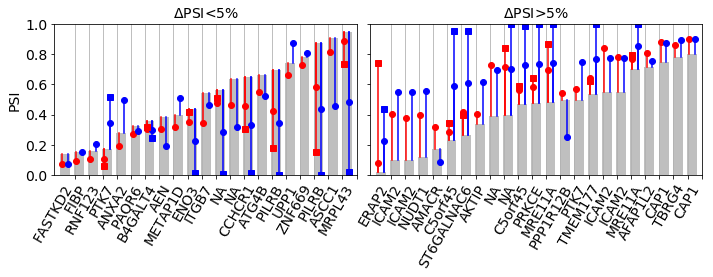

In [54]:
c1 = 'r'
c2 = 'b'
fsize = 14
fig = figure(figsize=(9,7))

SNP_SD_HETERO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HETERO_COUNTS.apply(size)>=2)&SNP_df.SS_MUT]

SNP_df.sort('WT_PSI')
SNP_SD = SNP_SD_HETERO[(SNP_SD_HETERO.SD1_MUT)&(SNP_SD_HETERO.LARGE_HETERO_EFFECT)]
cur_df = SNP_SD[SNP_SD.HETERO_DPSI<0]
n1 = float(len(cur_df))
n = float(len(SNP_SD))

cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([0,0.5,n1/n-0.01,0.3])
plot_snps(ax,cur_df)
title('$\Delta$PSI<5%',fontsize=fsize)
ax.set_ylabel('PSI',fontsize=fsize)


cur_df = SNP_SD[SNP_SD.HETERO_DPSI>0]
cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([n1/n+0.01,0.5,1-n1/n-0.01,0.3])
plot_snps(ax,cur_df,False)
title('$\Delta$PSI>5%',fontsize=fsize)

handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color=c1, marker='o', linestyle='')
heteroArtist = plt.Line2D((0,1),(0,0), color=c1, marker='s', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color=c2, marker='o', linestyle='')
homoArtist = plt.Line2D((0,1),(0,0), color=c2, marker='s', linestyle='')
SD_snp = plt.Line2D((0,0),(1,0), color='g', marker='', linestyle='-',linewidth=4)



### Plot SNPs in second SD:

/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/opt/modules/i12g/anaconda/3-4.1.1/envs/dev_concise/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


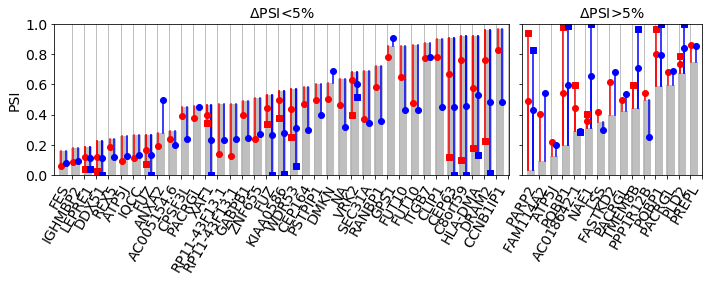

In [55]:
c1 = 'r'
c2 = 'b'
fsize = 14with h5py.File(train_data_file, "r") as train_data, h5py.File(val_data_file, "r") as val_data:
        sample_count = int(train_data.attrs["sample_count"])
        sample_idxs = range(0, sample_count)
        training_sample_idxs = np.random.permutation(sample_idxs)
 
        sample_count = int(val_data.attrs["sample_count"])
        sample_idxs = range(0, sample_count)
        validation_sample_idxs = np.random.permutation(sample_idxs)
        
        training_sequence_generator = generate_training_sequences(batch_size,
                                                                   train_data,
                                                                   training_sample_idxs)
        validation_sequence_generator = generate_validation_sequences(batch_size,
                                                                       val_data,
                                                                       validation_sample_idxs)
fig = figure(figsize=(9,7))

SNP_df.sort('WT_PSI')
SNP_SD = SNP_SD_HETERO[(SNP_SD_HETERO.SD2_MUT)&(SNP_SD_HETERO.LARGE_HETERO_EFFECT)]
cur_df = SNP_SD[SNP_SD.HETERO_DPSI<0]
n1 = float(len(cur_df))
n = float(len(SNP_SD))

cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([0,0.0,n1/n-0.01,0.3])
plot_snps(ax,cur_df)
title('$\Delta$PSI<5%',fontsize=fsize)
ax.set_ylabel('PSI',fontsize=fsize)


cur_df = SNP_SD[SNP_SD.HETERO_DPSI>0]
cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([n1/n+0.01,0.0,1-n1/n-0.01,0.3])
plot_snps(ax,cur_df,False)
title('$\Delta$PSI>5%',fontsize=fsize)


### Plot SNPs in SD Predictions Against HAL

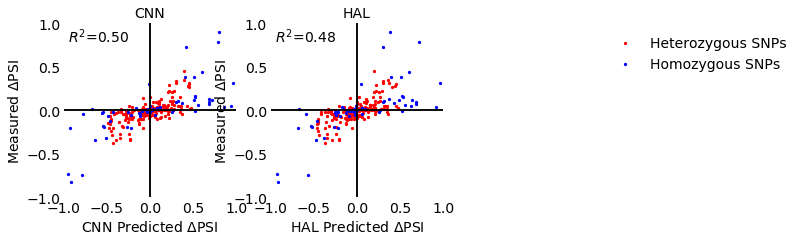

In [56]:
scaling_factor=0.8
inds_hetero = find((SNP_df.HETERO_COUNTS.apply(size)>=2) & (SNP_df.WT_COUNTS.apply(size)>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
fig = figure(figsize=(8.5*scaling_factor,4*scaling_factor))
ax = fig.add_subplot(121)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.scatter(SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED,
           SNP_df.iloc[inds_hetero].HETERO_DPSI,
           color='r',s=5,label='Heterozygous SNPs')
inds_homo = find((SNP_df.HOMO_COUNTS.apply(size)>=2) & (SNP_df.WT_COUNTS.apply(size)>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
ax.scatter(SNP_df.iloc[inds_homo].HOMO_DPSI_PRED,with h5py.File(train_data_file, "r") as train_data, h5py.File(val_data_file, "r") as val_data:
        sample_count = int(train_data.attrs["sample_count"])
        sample_idxs = range(0, sample_count)
        training_sample_idxs = np.random.permutation(sample_idxs)
 
        sample_count = int(val_data.attrs["sample_count"])
        sample_idxs = range(0, sample_count)
        validation_sample_idxs = np.random.permutation(sample_idxs)
        
        training_sequence_generator = generate_training_sequences(batch_size,
                                                                   train_data,
                                                                   training_sample_idxs)
        validation_sequence_generator = generate_validation_sequences(batch_size,
                                                                       val_data,
                                                                       validation_sample_idxs)
           SNP_df.iloc[inds_homo].HOMO_DPSI,
           color='b',s=5,label='Homozygous SNPs') 
r2= scipy.stats.pearsonr(np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI)),
                         np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI_PRED)))[0]**2
ax.set_ylabel('Measured $\Delta$PSI',fontsize=fsize)
ax.set_xlabel('CNN Predicted $\Delta$PSI',fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.axis([-1,1,-1,1])
ax.text(-0.95,0.96,'$R^2$=%0.2f' %r2,fontsize=fsize,ha='left',va='top')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.tick_params(size=0)
ax.set_title("CNN", fontsize=fsize)

ax = fig.add_subplot(122)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.scatter(SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED_HAL,
           SNP_df.iloc[inds_hetero].HETERO_DPSI,
           color='r',s=5,label='Heterozygous SNPs')
inds_homo = find((SNP_df.HOMO_COUNTS.apply(size)>=2) & (SNP_df.WT_COUNTS.apply(size)>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
ax.scatter(SNP_df.iloc[inds_homo].HOMO_DPSI_PRED_HAL,
           SNP_df.iloc[inds_homo].HOMO_DPSI,
           color='b',s=5,label='Homozygous SNPs') 
r2= scipy.stats.pearsonr(np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI)),
                         np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED_HAL,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI_PRED_HAL)))[0]**2
ax.set_ylabel('Measured $\Delta$PSI',fontsize=fsize)
ax.set_xlabel('HAL Predicted $\Delta$PSI',fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.axis([-1,1,-1,1])
ax.text(-0.95,0.96,'$R^2$=%0.2f' %r2,fontsize=fsize,ha='left',va='top')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.tick_params(size=0)
ax.set_title("HAL", fontsize=fsize)

leg = ax.legend(bbox_to_anchor=(1.9,1),scatterpoints=1,fontsize=fsize)
leg.get_frame().set_alpha(0)